In [2]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, DoubleTensorType
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np

## Load Mnist dataset with 28x28 grayscale images

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = list(map(int, y))

initial_types = [('input', FloatTensorType([1, X.shape[1]]))]

## Show a MNIST digit with "byte" info

<AxesSubplot:>

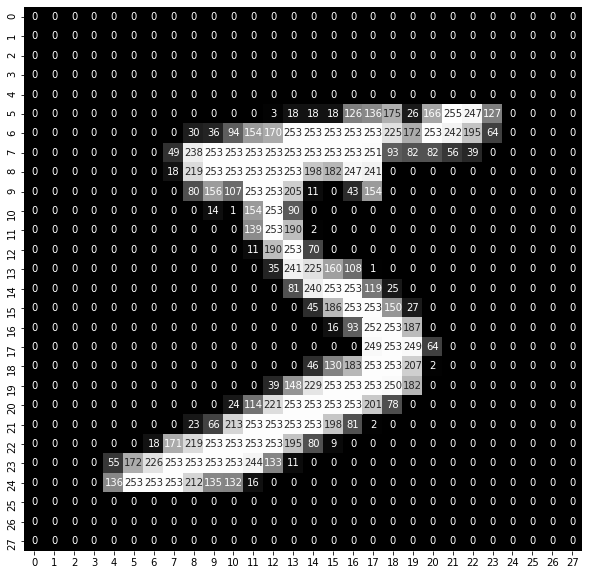

In [4]:
first_digit = X[0].reshape(28,28)
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(first_digit),annot=True,fmt=".0f", cmap="gray",cbar=False)

## Decide how many "PRINCIPALS" to use for reducing dimensionality, and thus, filesizes

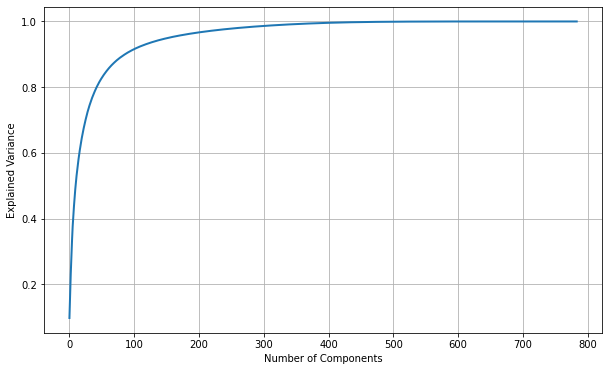

In [5]:
pca = PCA()
pca.n_components = 784

### Numpy 1.19.5 produces non-convergance random error on first pass, so retry if necessary ###
while True: 
    try: 
        pca_data = pca.fit_transform(X=X) 
        break 
    except: 
        continue

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(10, 6))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

## Pycaret model comparison

In [11]:
from pycaret.classification import *
### Sampling ####
X2=pd.DataFrame(X).sample(n=7000, random_state=1)
y2=pd.DataFrame(y).sample(n=7000, random_state=1)
X2['y']=y2
CaretModel = setup(data = X2, target = 'y', silent=True)
best = compare_models(exclude = ['catboost']) # CatBoost demora mucho

In [14]:
tuned = tune_model(LogisticRegression().fit(X, y),n_iter = 1000)
tuned

LogisticRegression(C=0.087, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## LogisticRegression

In [7]:
MnistModelLR = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pca',PCA(n_components=300)),
                             ('lr',LogisticRegression(C=3))]).fit(X, y)
crossval = cross_val_score(MnistModelLR, X,y)
print("Cross Validation:",crossval)
print("Score:",crossval.mean())

Cross Validation: [0.92007143 0.92214286 0.91721429 0.92014286 0.93114286]
Score: 0.9221428571428574


In [8]:
onx = convert_sklearn(MnistModelLR, initial_types=initial_types)
with open("MnistLR.onnx", "wb") as file:
    file.write(onx.SerializeToString())

In [9]:
with open('MnistLR.pkl', 'wb') as file:
    pickle.dump(MnistModelLR, file)

## KNeighborsClassifier

In [8]:
MnistModelKNN = Pipeline(steps=[('scaler',MinMaxScaler()),
                             ('pca',PCA(n_components=55)),
                             ('knn',KNeighborsClassifier(n_neighbors=3))]).fit(X, y)

crossval = cross_val_score(MnistModelKNN, X,y)
print("Cross Validation:",crossval)
print("Score:",crossval.mean())

Cross Validation: [0.978      0.97707143 0.97614286 0.97307143 0.9765    ]
Score: 0.976157142857143


In [9]:
onx = convert_sklearn(MnistModelKNN, initial_types=initial_types)
with open("MnistKNN.onnx", "wb") as file:
    file.write(onx.SerializeToString())

In [10]:
with open('MnistKNN.pkl', 'wb') as file:
    pickle.dump(MnistModelKNN, file)

## RandomForestClassifier

In [4]:
MnistModelRF = Pipeline(steps=[('scaler',MinMaxScaler()),
                             ('pca',PCA(n_components=100)),
                             ('rt',RandomForestClassifier(n_estimators=150))]).fit(X, y)
crossval = cross_val_score(MnistModelRF, X,y)
print("Cross Validation:",crossval)
print("Score:",crossval.mean())                             

Cross Validation: [0.95314286 0.94978571 0.94928571 0.94892857 0.95642857]
Score: 0.9515142857142858


In [12]:
onx = convert_sklearn(MnistModelRF, initial_types=initial_types)
with open("MnistRF.onnx", "wb") as file:
    file.write(onx.SerializeToString())


In [13]:
with open('MnistRF.pkl', 'wb') as file:
    pickle.dump(MnistModelRF, file)

## ExtraTreesClassifier

In [5]:
MnistModelET = Pipeline(steps=[('scaler',MinMaxScaler()),
                             ('pca',PCA(n_components=100)),
                             ('et',ExtraTreesClassifier(n_estimators=150))]).fit(X, y)
crossval = cross_val_score(MnistModelET, X,y)
print("Cross Validation:",crossval)
print("Score:",crossval.mean())

Cross Validation: [0.95492857 0.9555     0.95478571 0.95407143 0.961     ]
Score: 0.9560571428571428


In [15]:
onx = convert_sklearn(MnistModelET, initial_types=initial_types)
with open("MnistET.onnx", "wb") as file:
    file.write(onx.SerializeToString())

In [16]:
with open('MnistET.pkl', 'wb') as file:
    pickle.dump(MnistModelET, file)